# Comparison of ways to quantify free space

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import json
import python_files.space as sp
from python_files.data_extracter import json_extracter
import pandas as pd

data,events=json_extracter('data/match1_1_4.json')

## Quantify visual space occupation
---

In the notebook [1_Introduction_to_space_occupation](https://nbviewer.jupyter.org/github/AmigoCap/MecaFootCo/blob/master/1_Introduction_to_space_occupation.ipynb), we introduced metrics to compute visualization of space occupation and we visually compared our two metrics $\delta_d$ and $\delta_t$. Now we want to go further than just qualitative aspect.

### Evolution of teams occupation

To evaluate quantitatively how a team occupy the court, we integrate functions $\delta_d(x,y)$ and $\delta_t(x,y)$ on the basketball court.

In [2]:
def teams_occupation(events,event_id,mom_id,n=50,p=94):

    event=events[event_id]
    moment=event['moments'][mom_id]
    moment1=moment
    moment2=event['moments'][mom_id+1]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=sp.players_ball_speed_position(moment1,moment2)
    
    DELTA_D=0
    for i in range(n):
        for j in range(p):
            b=np.array([j,i]) # point d'arrivée

            dmin_1=np.inf
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                d=sp.distance(a,b)
                if d<dmin_1:
                    dmin_1=d

            dmin_2=np.inf
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                d=sp.distance(a,b)
                if d<dmin_2:
                    dmin_2=d
            DELTA_D+=dmin_1-dmin_2
            
    return(DELTA_D)

In [3]:
def teams_occupation_inertia(events,event_id,mom_id,n=50,p=94):
    
    event=events[event_id]
    moment=event['moments'][mom_id]
    moment1=moment
    moment2=event['moments'][mom_id+1]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=sp.players_ball_speed_position(moment1,moment2)
            
    DELTA_T=0
    for i in range(n):
        for j in range(p):
            b=np.array([j,i]) # point d'arrivée
        
            tmin_1=np.inf
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                t=sp.time_to_point(a,b,v)
                if t<tmin_1:
                    tmin_1=t
                    
            tmin_2=np.inf
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                t=sp.time_to_point(a,b,v)
                if t<tmin_2:
                    tmin_2=t
        
            DELTA_T+=tmin_1-tmin_2
    
    return(DELTA_T)

In [4]:
def court_evolution(events,event_id):
    event=events[event_id]
    moments=event['moments']
    times=[0 for i in range(len(moments)-1)]
    list_DELTA_D=[0 for i in range(len(moments)-1)]
    list_DELTA_T=[0 for i in range(len(moments)-1)]
    
    for mom_id in range(len(moments)-1):
        
        dt=moments[mom_id][2]-moments[mom_id+1][2]
        
        if mom_id==0:
                times[mom_id]=dt
        else :
            times[mom_id]=times[mom_id-1]+dt
                
        if sp.test_moment(moments[mom_id]) and sp.test_moment(moments[mom_id+1]):
            list_DELTA_D[mom_id]=teams_occupation(events,event_id,mom_id)
            list_DELTA_T[mom_id]=teams_occupation_inertia(events,event_id,mom_id)
        
        else:
            list_DELTA_D[mom_id]=list_DELTA_D[mom_id-1]
            list_DELTA_T[mom_id]=list_DELTA_T[mom_id-1]
            
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(times, list_DELTA_D, 'r-')
    ax2.plot(times, list_DELTA_T, 'b-')

    ax1.set_xlabel('times [s]')
    ax1.set_ylabel(r'$\sum(\delta_{d}(x,y))(t)$ [feets]', color='r')
    ax2.set_ylabel(r'$\sum(\delta_{t}(x,y))(t)$ [s]', color='b')

    plt.show()
    plt.plot

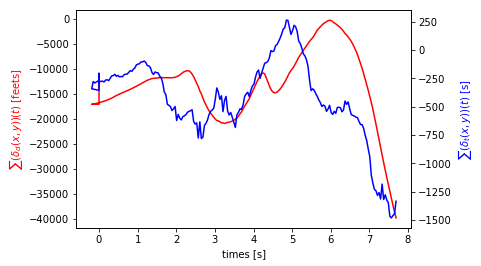

In [10]:
court_evolution(events,50)

We can see that both metrics reveal the same trend but with a delay in the time. The red curve seems to be late (about 1s). We will study this remark in the **Study of the delay** section.

### Introducing pressure on a player

Now we want to focus on individual space behaviour. Particularly, we would like to know how a player's freespace evolve during the game. Instead of computing the integrale of $\delta_d(x,y)$ and $\delta_t(x,y)$ around the player, we will look at the distance of the closest opponent (or the time it takes for the closest opponent to join the player). This amounts to calculating $\delta_d^*=\delta_d(x_{player},y_{player})$ and $\delta_t^*=\delta_t(x_{player},y_{player})$.

In [2]:
def player_freespace(events,event_id,mom_id,player_id):
    event=events[event_id]
    moment=event['moments'][mom_id]
    
    delta_d=sp.distance_closest_opponent(moment,player_id)
    
    return(delta_d)

In [3]:
def player_freetime(events,event_id,mom_id,player_id):
    event=events[event_id]
    moment1=event['moments'][mom_id]
    moment2=event['moments'][mom_id+1]
    
    delta_t=sp.time_closest_opponent(moment1,moment2,player_id)
    
    return(delta_t)

In [4]:
def player_freespace_evolution(events,event_id,player_id):
    event=events[event_id]
    moments=event['moments']
    
    start=0
    dt=moments[start][2]-moments[start+1][2]
    
    while dt<=0 and start<(len(moments)-1):
        start+=1
        dt=moments[start][2]-moments[start+1][2]
    
    print(start)
    times=[0 for i in range(len(moments)-1)]
    list_delta_d=[0 for i in range(len(moments)-1)]
    list_delta_t=[0 for i in range(len(moments)-1)]
    
    for mom_id in range(start,len(moments)-1):
        
        dt=moments[mom_id][2]-moments[mom_id+1][2]

        if mom_id==0:
            times[mom_id]=dt
        else :
            times[mom_id]=times[mom_id-1]+dt
                
        if sp.test_moment(moments[mom_id]) and sp.test_moment(moments[mom_id+1]):
            list_delta_d[mom_id]=player_freespace(events,event_id,mom_id,player_id)
            list_delta_t[mom_id]=player_freetime(events,event_id,mom_id,player_id)
            
        else:
            list_delta_d[mom_id]=list_delta_d[mom_id-1]
            list_delta_t[mom_id]=list_delta_t[mom_id-1]
            
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(times[start:], list_delta_d[start:], 'r-')
    ax2.plot(times[start:], list_delta_t[start:], 'b-')

    ax1.set_xlabel('times [s]')
    ax1.set_ylabel(r'$\delta_{d}^*(t)$ [feets]', color='r')
    ax2.set_ylabel(r'$\delta_{t}^*(t)$ [s]', color='b')

    plt.show()
    plt.plot

Let's see which player are present on the court at that time :

In [100]:
def players_description(event):
    print('home : ',event['home']['name'],'\n')
    print(event['home']['players'],'\n')
    print('visitor : ',event['visitor']['name'],'\n')
    print(event['visitor']['players'])
    
def players_on_the_court(events,event_id):
    event=events[event_id]
    moments=event['moments']
    mom_id=10
    moment=moments[mom_id][5]
    print(moment)
    sp.print_court_teams_occupation(events,event_id,mom_id,player_info=True)

[[-1, -1, 9.96734, 52.36062, 2.90132], [1610612764, 2400, 69.24473, 18.24024, 0.0], [1610612764, 2403, 74.4225, 33.67206, 0.0], [1610612764, 202322, 82.22508, 8.45412, 0.0], [1610612764, 203078, 53.08712, 51.76333, 0.0], [1610612764, 203490, 85.70118, 36.13635, 0.0], [1610612759, 1938, 85.42162, 36.72985, 0.0], [1610612759, 2564, 74.12292, 20.48288, 0.0], [1610612759, 200746, 79.99431, 31.47998, 0.0], [1610612759, 201988, 83.15203, 9.9598, 0.0], [1610612759, 202695, 62.16725, 43.7584, 0.0]]


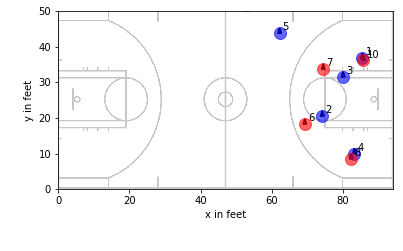

In [112]:
players_on_the_court(events,50)

We see that the player who has the ball is the player 10 with the ID 202695. Let's see which player he is.

In [13]:
players_description(events[50])

home :  Washington Wizards 

[{'lastname': 'Gooden', 'firstname': 'Drew', 'playerid': 2400, 'jersey': '90', 'position': 'F'}, {'lastname': 'Hilario', 'firstname': 'Nene', 'playerid': 2403, 'jersey': '42', 'position': 'F-C'}, {'lastname': 'Humphries', 'firstname': 'Kris', 'playerid': 2743, 'jersey': '43', 'position': 'F'}, {'lastname': 'Gortat', 'firstname': 'Marcin', 'playerid': 101162, 'jersey': '13', 'position': 'C'}, {'lastname': 'Dudley', 'firstname': 'Jared', 'playerid': 201162, 'jersey': '1', 'position': 'G-F'}, {'lastname': 'Sessions', 'firstname': 'Ramon', 'playerid': 201196, 'jersey': '7', 'position': 'G'}, {'lastname': 'Blair', 'firstname': 'DeJuan', 'playerid': 201971, 'jersey': '45', 'position': 'C-F'}, {'lastname': 'Temple', 'firstname': 'Garrett', 'playerid': 202066, 'jersey': '17', 'position': 'G'}, {'lastname': 'Wall', 'firstname': 'John', 'playerid': 202322, 'jersey': '2', 'position': 'G'}, {'lastname': 'Neal', 'firstname': 'Gary', 'playerid': 202390, 'jersey': '14', '

It's Kawhi Leonard. Let's see his *freespace* evolution during this action

125


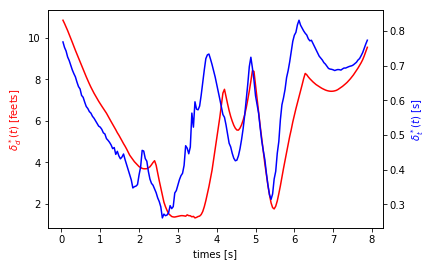

In [114]:
player_freespace_evolution(events,50,202695)

As for teams occupation, comparing player's *freespace* (distance to his closest opponent) and player's *freetime* (time needed for his closest opponent to reach him) reveals a delay close to 0.3-0.5s. We are going to quantify these delays in the following section.

## Study of the delay
-----

### *occupation-map* delay

Firstly, as *occupation-map* generated with $\delta_t$ seems to lag *occupation-map* generated with $\delta_t$, let's draw these shifted maps for a few moments to see if they fit better.

In [27]:
data,events=json_extracter('data/game1.json')

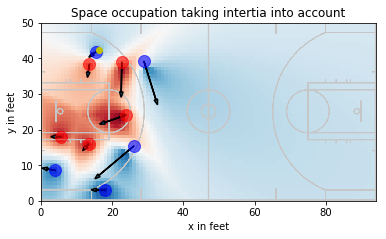

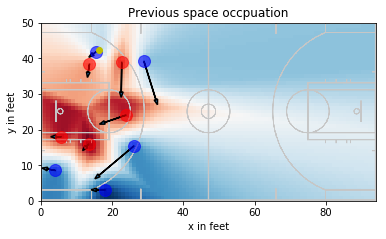

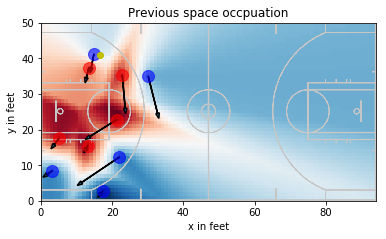

In [28]:
plt.figure(1)
plt.title('Space occupation taking intertia into account')
sp.print_court_teams_occupation_inertia(events,0,25)
plt.figure(2)
plt.title('Previous space occpuation')
sp.print_court_teams_occupation(events,0,25,value=True)
plt.figure(3)
plt.title('Previous space occpuation')
sp.print_court_teams_occupation(events,0,35,value=True)

We are going to try to quantify this observation. To do so, we calculate the correlation between space occupation with time and distance model and it will give us the lag. As force is the factor that can change in our study, we calculate the correlation for different forces and then we look the evolution of the correlation in function of forces. Here are the results.

In [3]:
import pandas as pd
lags=pd.read_csv('data/total_df_final.csv',sep = ',',index_col=[0,1,2])
lags.dropna(inplace=True)

In [4]:
lags.head(10)

R  tau       rho   time
  Unnamed: 0.1 Unnamed: 2                                
1 2            0           0.063110   77  0.379596  20.47
               1           0.064491   77  0.379596  20.47
               2           0.065823   77  0.379596  20.47
               3           0.067178   77  0.379596  20.47
               4           0.068361   77  0.379596  20.47
               5           0.069243   77  0.379596  20.47
               6           0.070035   77  0.379596  20.47
               7           0.070769   77  0.379596  20.47
               8           0.071682   77  0.379596  20.47
               9           0.072152   77  0.379596  20.47

Time of the study

#### Correlation max function of force

First we look at the correlation max function of the force. 

In [5]:
df=lags[['rho','time']].max(level=(0,1))
df.head(10)
df.loc[1]['time'].sum()

593.77

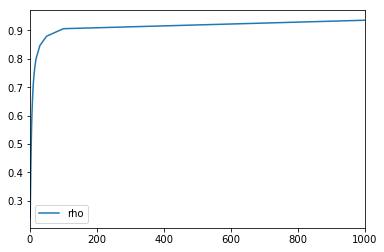

In [6]:
rho_mean=df[['rho']].mean(level=(0))
rho_mean.plot()

In [7]:
rho_mean

,rho
1,0.239649
2,0.335432
3,0.423903
4,0.494546
5,0.552128
6,0.596814
7,0.632238
8,0.661400
9,0.685661
10,0.705990


Let's drop too big values of f to see more details. Let's also plot the deviation

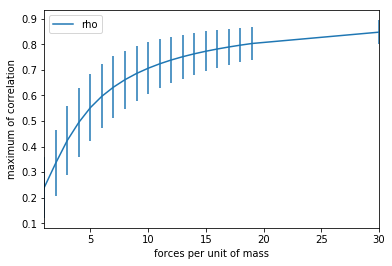

In [8]:
fig, ax = plt.subplots()
rho_mean=df.drop([50,100,1000])[['rho']].mean(level=(0))
rho_std=df.drop([50,100,1000])[['rho']].std(level=(0))
rho_mean.plot(yerr=rho_std, ax=ax)
plt.xlabel('forces per unit of mass')
plt.ylabel('maximum of correlation')

Let's make an average for each force weighed by the time of the sequence.

In [9]:
import numpy as np

In [10]:
def weighted(row, cols, w="time"):
    return (np.average(row[cols], weights=row[w]))


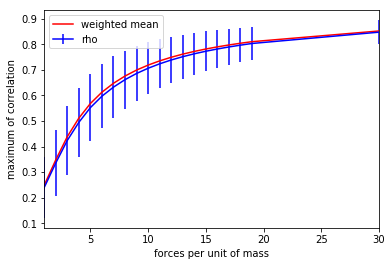

In [11]:
rho_mean_w=df.drop([50,100,1000]).groupby(level=0).apply(weighted, cols='rho', w='time')
fig, ax = plt.subplots()
rho_mean.plot(yerr=rho_std, ax=ax, color='b', label='mean')
rho_mean_w.plot(ax=ax, color='r', label='weighted mean')
plt.xlabel('forces per unit of mass')
plt.ylabel('maximum of correlation')
plt.legend()

We can see that there are little differences when weighted the mean. However, the curve seems to be clause to 1-1/exp. Let's compare

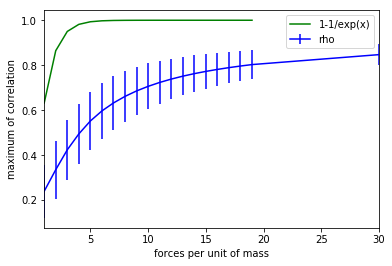

In [12]:
fig, ax = plt.subplots()
rho_mean.plot(yerr=rho_std, ax=ax, color='b', label='mean')
x=np.arange(1,20,1)
y=1-1/np.exp(x)
plt.plot(x,y,'green',label='1-1/exp(x)')
plt.xlabel('forces per unit of mass')
plt.ylabel('maximum of correlation')
plt.legend()

(0.082357099357977248, 1)

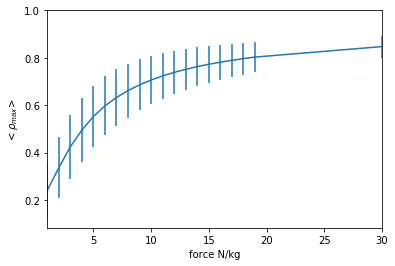

In [43]:
fig, ax = plt.subplots()
rho_mean.plot(yerr=rho_std, ax=ax, legend=False)
x=np.arange(1,12,1)
x2=np.arange(5,31,1)
y=0.095783*x+0.143866
y2=1+0*x2
plt.xlabel('force N/kg')
plt.ylabel(r'$<\rho_{max}$>')
plt.ylim(top=1)

It seems that for 10N/kg, the increase decreases.

#### Lag function of force

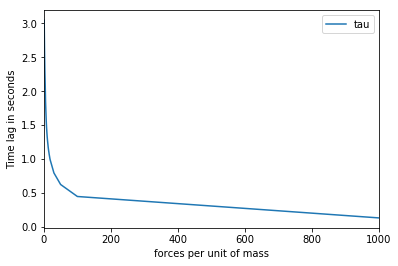

In [14]:
df=lags[['tau','time']].max(level=(0,1))
df['tau']=df['tau']*0.04
fig, ax = plt.subplots()
tau_mean=df[['tau']].mean(level=(0))
tau_mean.plot(ax=ax)
plt.xlabel('forces per unit of mass')
plt.ylabel('Time lag in seconds')
plt.legend()

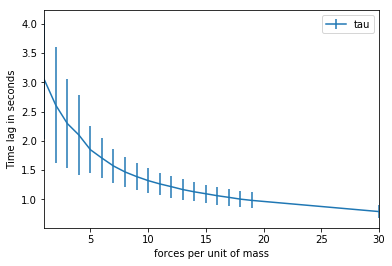

In [15]:
fig, ax = plt.subplots()
tau_mean=df.drop([50,100,1000])[['tau']].mean(level=(0))
tau_std=df.drop([50,100,1000])[['tau']].std(level=(0))
tau_mean.plot(yerr=tau_std, ax=ax)
plt.xlabel('forces per unit of mass')
plt.ylabel('Time lag in seconds')
plt.legend()

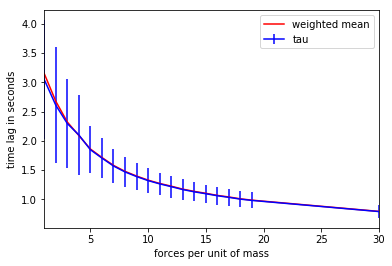

In [16]:
tau_mean_w=df.drop([50,100,1000]).groupby(level=0).apply(weighted, cols='tau', w='time')
fig, ax = plt.subplots()
tau_mean.plot(yerr=tau_std, ax=ax, color='b', label='mean')
tau_mean_w.plot(ax=ax, color='r', label='weighted mean')
plt.xlabel('forces per unit of mass')
plt.ylabel('time lag in seconds')
plt.legend()

#### Correlations in the same plot

/Users/gabin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """


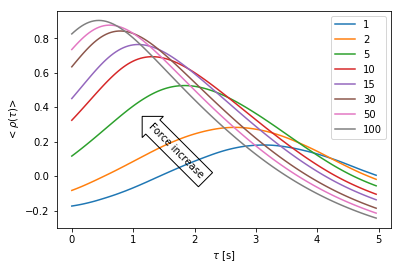

In [44]:
fig, ax = plt.subplots()
Rho=lags[['R']].mean(level=(0,2))
ind=[1,2,5,10,15,30,50,100]
for i in ind:
    time=lags.loc[(1,2)].index*0.04
    plt.plot(time,Rho.loc[i],label=str(i))
plt.legend()
bbox_props = dict(boxstyle="larrow,pad=0.5",fc='None')
plt.text(1.7, 0.15, "Force increase", ha="center", va="center", rotation=-45,
            size=10,
            bbox=bbox_props)
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'$<\rho(\tau)$>')

In [54]:
df=lags[['tau','time']].max(level=(0,1))
tau_mean=df[['tau']].mean(level=(0))
tau_mean.loc[10]

tau    33.030303
Name: 10, dtype: float64

Let's test visually the result : for a force of 10N/kg, the lag is closed to 34 moments, it means that if we want to test visually we have to shift distance court of 33 moments. Let's test

First let's plot court heat-map with distance model

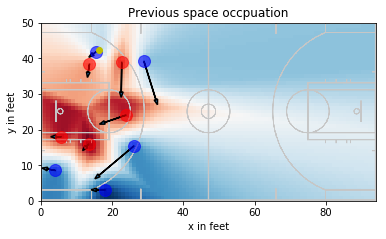

In [6]:
plt.figure(1)
plt.title('gtPrevious space occpuation')
sp.print_court_teams_occupation(events,0,25,value=True)

Then the court heat-map with the speed model

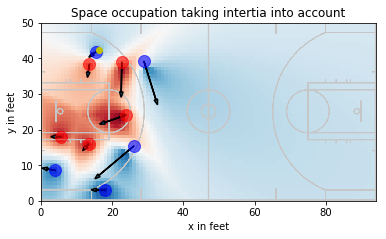

In [7]:
plt.figure(2)
plt.title('Space occupation taking intertia into account')
sp.print_court_teams_occupation_inertia(events,0,25)

Finally the court heat-map with distance model shifted of 33 moments

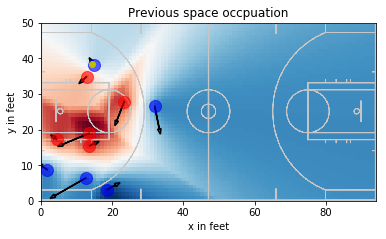

In [73]:
plt.figure(3)
plt.title('Previous space occpuation')
sp.print_court_teams_occupation(events,0,58,value=True)

In [22]:
tau_mean.loc[10]

tau    1.321212
Name: 10, dtype: float64

### Delay between individual *freespace* and *freetime*